In [2]:
import os 
cwd = os.getcwd()
import sys
sys.path.append("C:/Users/gomel/Documents/global_python_codes/Metrics_thresholds_boots") # go to parent dir

sys.path.append("C:/Users/gomel/Documents/Programing Proyects/EE indicators/Simulations with pdfs to test/Stochastic equations/SDE tests jupyter") # go to parent dir
import sde_analysis as sa

import sympy as sp
import ewstools as ews
import numpy as np
import sdeint
import metrics
import boots as bts
import scipy.stats as st
import astropy.stats as astrost
import scipy.signal as sg
from scipy import special

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"    
})
import matplotlib.lines as lines
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

from sympy import lambdify

c1=(221/256,170/256,51/256)
c2=(187/256,85/256,102/256)
c3=(0,68/256,136/256)
cols=(c1,c2,c3)

This is a simulation of a onlinear equation with aditive noise using a Heun method where the noise only applies on the variable and not the parameter. 

\begin{equation}
\dot{x}=\lambda  x+x^3-x^5
\end{equation}

where $x$ is a random variable and $r$ is a swiped parameter determined by $\dot{\lambda }=c_\lambda $. Here $c_\lambda $ should be small enough for the parameter to be moving 'adiabatically' with respect to the dynamics of the system. 


This system has three fixed points, $x={0,\pm \sqrt{1/2}\sqrt{1\pm\sqrt{1+4\lambda }}}$ that switch stability depending on the sign of $r$.
By starting with an initial condition $x=1.5,\lambda _0=5$ we stay on the stable manifold after crossing the threshold $\lambda =0$ and the system goes through a tipping point to another stable solution.

$f'=\lambda +3x^3-5x^4$

$f''=6x^2-20x^3$


 # update this
The stochastic equation is 

\begin{equation}
dx=\lambda x+x^3-x^5dt +\sigma dW
\end{equation}

where W is a (0,1) white noise process and $\sigma$ the intensity of the noise. Here $\dot{x}=\lambda (x-2)(x-1)(x-3)$ is called the deterministic skeleton of the stochastic equation.



In [3]:
xs, ls = sp.symbols('xs lambda')
eq=(ls*(xs)+(xs)**3-(xs)**5)
M=ls+3*xs**2-5*xs**4
sp.solve(eq, xs)


[0,
 -sqrt(1/2 - sqrt(4*lambda + 1)/2),
 sqrt(1/2 - sqrt(4*lambda + 1)/2),
 -sqrt(sqrt(4*lambda + 1)/2 + 1/2),
 sqrt(sqrt(4*lambda + 1)/2 + 1/2)]

In [4]:

sol1=sp.sqrt(sp.sqrt(4*ls + 1)/2 + 1/2)
sp_dxdl=sp.diff(sol1,ls)


Mr=M.subs(xs, sol1)
Mr

cl= sp.symbols('c')
rl= sp.symbols('r')

adiab=sp.solve(ls/0.02+1/(2*Mr), ls)
adiab=sp.N(adiab[0]) 
ad1 = lambdify([ls],ls/0.1+1/(2*Mr))


ad0 = lambdify([ls],ls/0.1-1/(2*ls))
radiab=sp.solve(0.1/(Mr)-1, ls)
Mr

lambda + 3*sqrt(4*lambda + 1)/2 - 5*(sqrt(4*lambda + 1) + 1)**2/4 + 3/2

In [5]:
def m_sol1(mvar):
    mv=mvar[mvar>-0.25]
    return 1/np.sqrt(2)*np.sqrt(1+np.sqrt(1+4*mv))
def m_sol2(mvar):
    mv=mvar[mvar>-0.25]
    return -1/np.sqrt(2)*np.sqrt(1+np.sqrt(1+4*mv))
def m_inest_1(mvar):
    mv=mvar[(mvar<0) & (mvar>-0.25)]
    return 1/np.sqrt(2)*np.sqrt(1-np.sqrt(1+4*mv))
def m_inest_2(mvar):
    mv=mvar[(mvar<0) & (mvar>-0.25)]
    return -1/np.sqrt(2)*np.sqrt(1-np.sqrt(1+4*mv))



### Characteristic time-scale exploration

First we do a deterministic integration to estimate the time-scale of the transition.

In [6]:
l0=2
lf=-2
cls=0.001
cl=np.sign(lf-l0)*cls
s=0.01


adiab=sp.solve(ls/cl+1/(2*Mr), ls)
adiab=sp.N(adiab[0]) 
ad1 = lambdify([ls],ls/cl+1/(2*Mr))

adiab2=sp.solve(ls/cl+1/(Mr), ls)
adiab2=sp.N(adiab2[0]) 
ad2 = lambdify([ls],ls/cl+1/(Mr))
adiab3=sp.solve(ls/cls+10/(Mr), ls)
adiab3=sp.N(adiab3[0]) 
M1 = lambdify([ls],Mr)
adiab_cl=sp.solve(ls/cls+3/(Mr), ls)
adiab_cl=sp.N(adiab_cl[0]) 


t_final=(lf-l0)/cl
t_rm=np.abs(1/M1(l0))
t_threshold=t_rm/2
dt=t_threshold/4
t_win=t_rm/dt ### length of correlation. 
    
datalen=t_final/(600*7*10)
if datalen>=t_threshold/4: 
    datalen=t_threshold/4
    
tspan=np.arange(0,t_final,datalen)
print(r'$\Delta t= $', tspan[1]-tspan[0], 't_final:', t_final)
print('correlation time: ', t_win)
print('data length: ', len(tspan))
print('dot lambda: ', cl)

x0 = np.array([1/np.sqrt(2)*np.sqrt(1+np.sqrt(1+4*l0))])
 #       x0= np.array([0.]) 

def f(x, t):
    #X=x[0]. dot(x)=r(x-2)*(x-1)*(x-3)
    #r=x[1]. dot(r)=cte.  This is a constant swipe of parameter r at speed dot(r). 
#    A=np.array([x[1]*x[0]+x[0]**3-x[0]**5,-2*r0/t_final*special.erf(x[1]) ])
    l=l0+cl*t
    A=np.array([(l*(x[0])+(x[0])**3-(x[0])**5)])
    return A

def G(x, t):
    #B=[ 'noise in x'         0    ]
    #  [      0        'noise in r']
    B = np.diag([s]) # diagonal, so independent driving Wiener processes
    #the only parameter with relevant aditive noise is X(t) in this case. 
    return B
np.random.seed(1) #set numpy.random seed for reproducibility whenever it might be used.
l_var=np.linspace(lf,l0,20)
l=l0+cl*tspan
dl=cl*tspan[1]-l0


result = sdeint.stratHeun(f, G, x0, tspan)
print('Integration DOOONNEE')


$\Delta t= $ 0.010416666666666666 t_final: 4000.0
correlation time:  8.0
data length:  384000
dot lambda:  -0.001
Integration DOOONNEE


In [7]:
adiab=sp.solve(-Mr*(ls)/cls+1, ls)
adiab=sp.N(adiab[0]) 
adiab

-0.249996031558052

In [8]:
adiab2

-0.249996031558052

In [9]:
adiab3=sp.solve(-Mr*(ls)/cls+10, ls)
adiab3=sp.N(adiab3[0]) 
adiab3

-0.249628053769097

In [10]:
adiab3=sp.solve(-Mr*(ls)/cls+3, ls)
adiab3=sp.N(adiab3[0]) 
adiab3

-0.249964829140102

In [11]:
t_rm/dt

8.0

<lambdifygenerated-25>:2: RuntimeWarning: invalid value encountered in sqrt
  return lambda_ + (3/2)*sqrt(4*lambda_ + 1) - 5/4*(sqrt(4*lambda_ + 1) + 1)**2 + 3/2


7998.874532482921

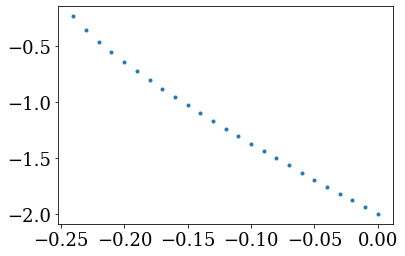

In [45]:
bif_idx=np.abs(-0.25-l).argmin()
slow_idx=np.abs(adiab3-l).argmin()

fast_window=bif_idx-slow_idx
fast_window
adiab3

M_fun= lambdify([ls],Mr)
lvars=np.linspace(-10,0,1000)
plt.plot(lvars,M_fun(lvars),'.')

t_adiab0=-1/np.real(M1(complex(adiab2)))
t_adiab0/dt

t_adiab=-1/np.real(M_fun(complex(adiab3)))
t_adiab/dt

In [50]:

fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(111)
plt.plot(l,result[:,0],color=c2,zorder=9)
plt.plot(l[l>-0.25],np.sqrt(1/2)*np.sqrt(1+np.sqrt(1+4*l[l>-0.25])),'-',color='black')
plt.plot(l[l<0],0*l[l<0],'-k')
plt.plot(l[l>0],0*l[l>0],'--k',alpha=0.5)
plt.plot(l[(l<0) & (l>-0.25)],m_inest_1(l),'--k',alpha=0.5)
ylim=ax.get_ylim()
ax.set_xlim(np.min(l),np.max(l))

xlim=ax.get_xlim()
ax.plot([adiab,adiab],ylim,'-.',linewidth=2,color=c1,alpha=1,label='tracking')

ax.plot([adiab3,adiab3],ylim,'-.',linewidth=2,color=c3,alpha=1,label='tracking')
#lt.plot(result[result[:,1]>0,1],result[result[:,1]>0,0],'r')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$x$')
plt.rc('font',size=26)


if np.sign(cl)<0:
    t = ax.text(
        xlim[1]*0.8, 0.8*ylim[1], "$c_\lambda<0$", ha="center", va="center", rotation=0, size=20,
        bbox=dict(boxstyle="larrow,pad=0.3",fc="white", ec=c2, lw=3))
else:
    t = ax2.text(
    xlim[0]*0.8, 0.8*lim[1], "$c_\lambda>0$", ha="center", va="center", rotation=0, size=20,
    bbox=dict(boxstyle="rarrow,pad=0.3",fc="white", ec=c2, lw=3))
ax.set_title(r'$c_\lambda=%.1e ; \sigma=%.1e $ '%(cl,s))
fig.savefig('./bifurcation_additive.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI



#### Integration scheme: 

Here I use the sdeint python package to integrate based on the Heun scheme. This decision is based on the paper "Integration of stochastic differential equations on a computer" from R.Manella.
DOI: 10.1142/S0129183102004042


Here i do a set of 'n' runs to do statististics on: 

## Detrended

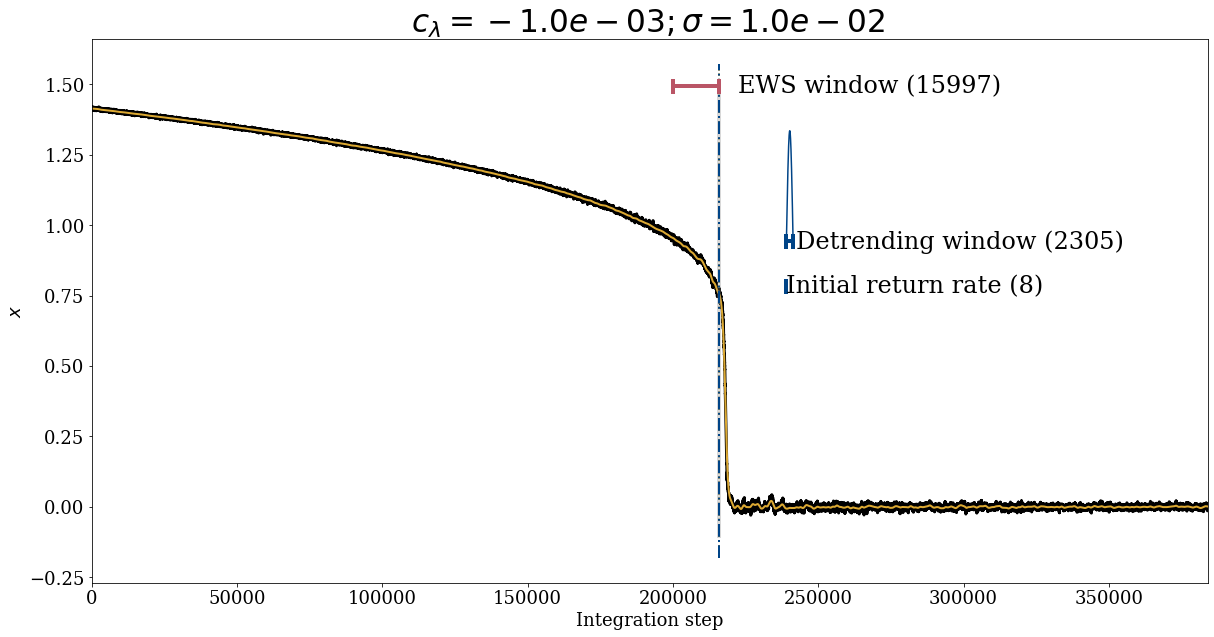

In [46]:
from scipy import signal

bootstrapping=False
smoothing=True


bif_idx=np.abs(-0.25-l).argmin()
adiab_idx=np.abs(adiab-l).argmin()
adiab2_idx=np.abs(adiab2-l).argmin()
adiab3_idx=np.abs(adiab3-l).argmin()

trans=bif_idx
res=result[:,0]
dlen=len(res)
t=np.arange(0,len(res),1)
ind_f=t


varwin=np.int64(3*t_win/dt+1)
ewswin=np.int64(2*np.int64(t_adiab/dt)+1)
ts = ews.TimeSeries(data=res)  ### ews stats ### 

bw=varwin/2
if smoothing==True:
    ts.detrend(method='Gaussian',bandwidth=bw, span=varwin)
    smooth=ts.state['smoothing'].values
    residuals=ts.state['residuals'].values
    data=residuals

    fig=plt.figure(figsize=(20,10))

    ax=fig.add_subplot(111)
    plt.plot(t,res,'-',color='black',lw=3)
    plt.plot(t,smooth,color=c1,lw=2)
    plt.xlim(t[0],t[-1])
    sa.plot_detrend(fig, ewswin,varwin,t_rm,dt,bw,trans)

ax.set_title(r'$c_\lambda=%.1e ; \sigma=%.1e $ '%(cl,s))

ylim=ax.get_ylim()

plt.rc('font',size=26)


ax.plot([adiab_idx,adiab_idx],ylim,':',linewidth=2,color=c1,alpha=1,label='Bifurcation')
ax.plot([adiab2_idx,adiab2_idx],ylim,'-.',linewidth=2,color=c1,alpha=1,label='Bifurcation')
ax.plot([adiab3_idx,adiab3_idx],ylim,'-.',linewidth=2,color=c3,alpha=1,label='Bifurcation')


fig.savefig('./detrend_additive.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI


#add windows and detrending information as an annotation

4798.151766708207

In [47]:
tidx,ac_labels,ac1,ac2,var_ews,sk_ews,ku_ews,rtw,hogg2,moors,RTWc= sa.make_stats(tspan,t,ts,varwin,ewswin,sm=smoothing)


if bootstrapping==True:
    dlen=len(ac1)
    mean_b=np.zeros([dlen,2])
    var_b=np.zeros([dlen,2])
    skew_b=np.zeros([dlen,2])
    kur_b=np.zeros([dlen,2])
    kr2_b=np.zeros([dlen,2])
    kr3_b=np.zeros([dlen,2])
    RTW_b=np.zeros([dlen,2])
    ac1_std=np.zeros([dlen,2])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


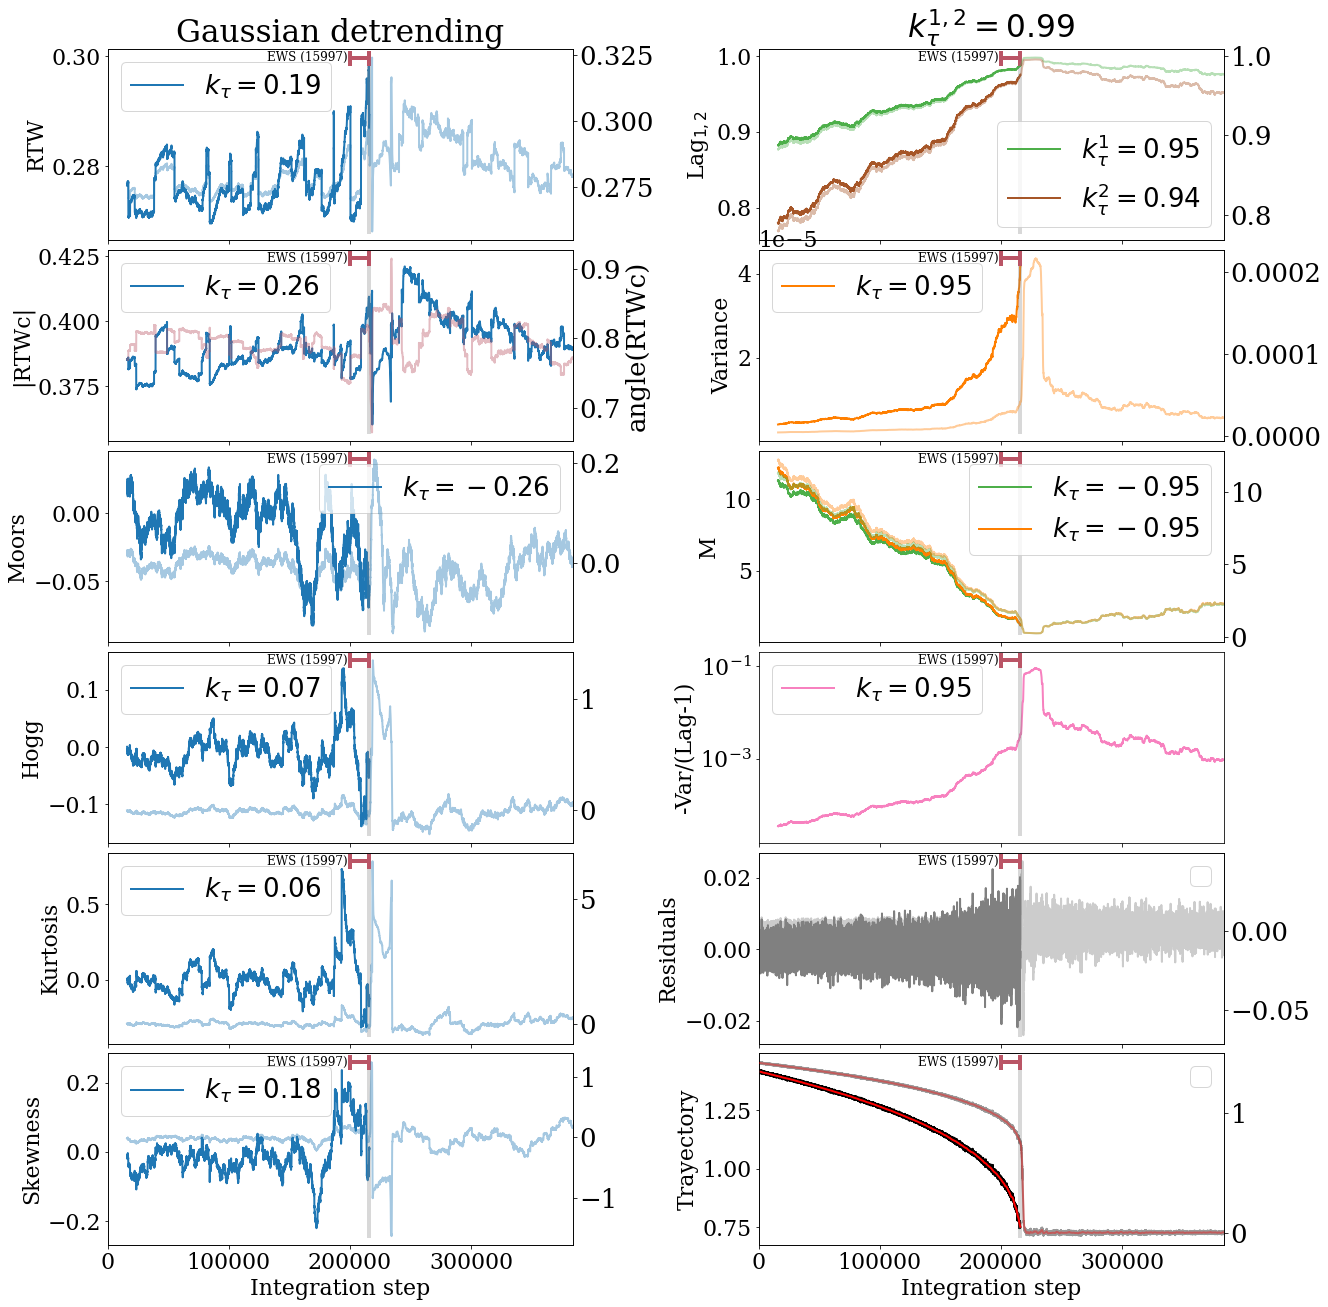

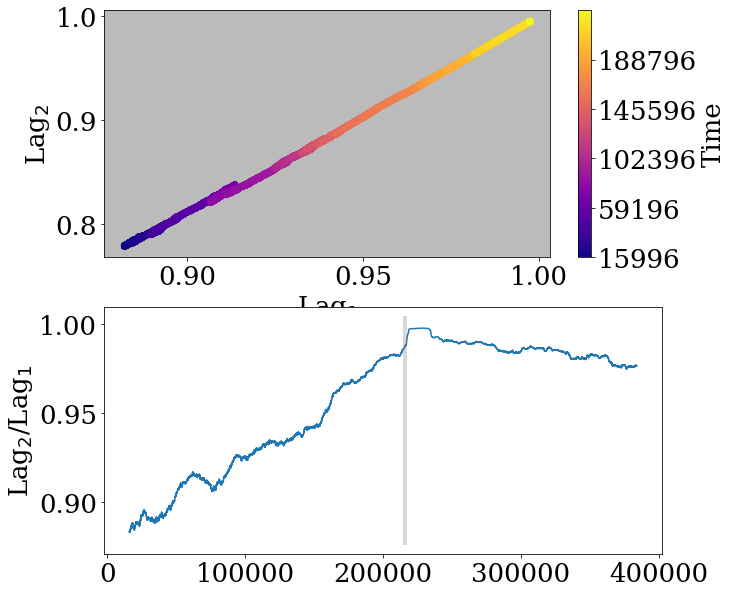

In [48]:
fig=sa.stats_plot(bif_idx,tidx,ind_f,s,rtw,RTWc,moors,hogg2,ac1,ku_ews,sk_ews,ac2,var_ews,residuals,res,smooth,smoothing,ewswin,datalen)
fig.savefig('./Gdet_additive.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI
fig=sa.ac12_plot(ac1,ac2,tidx,bif_idx)

## Non detrended data:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


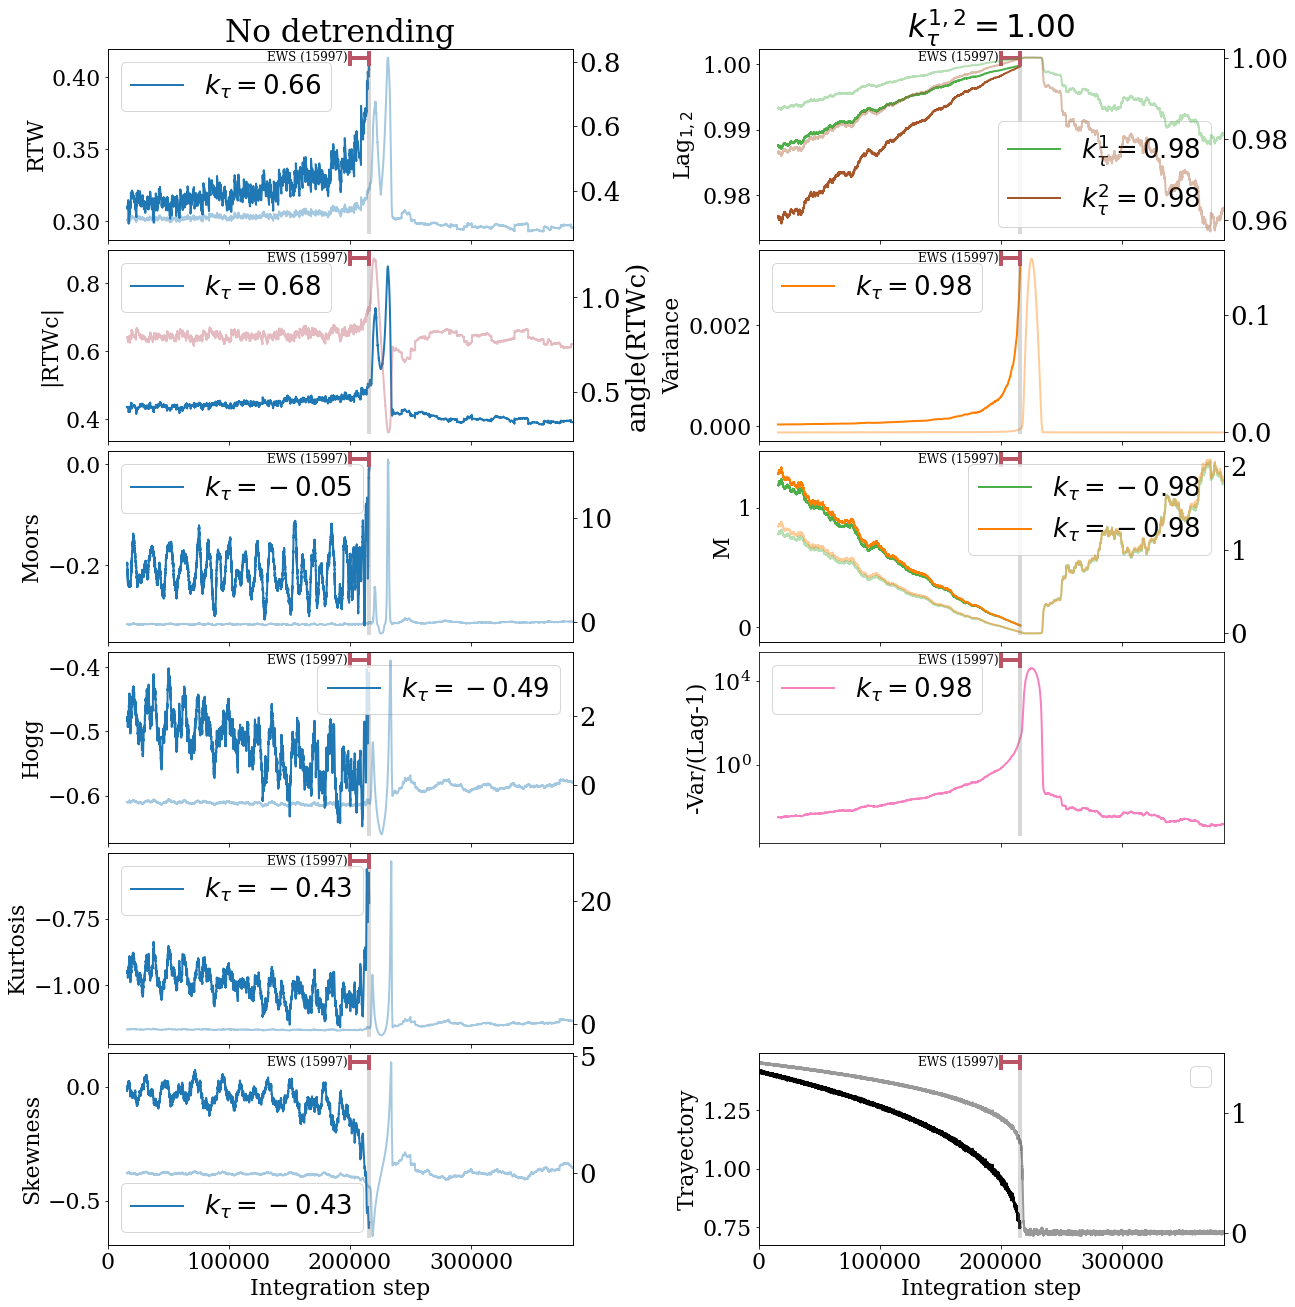

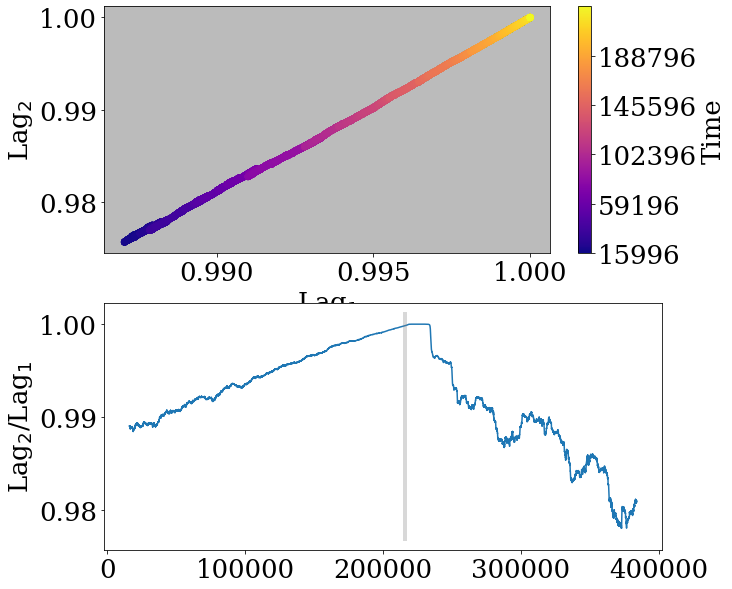

In [49]:

bootstrapping=False
smoothing=False

ts = ews.TimeSeries(data=res)  ### ews stats ### 
tidx,ac_labels,ac1,ac2,var_ews,sk_ews,ku_ews,rtw,hogg2,moors,RTWc= sa.make_stats(tspan,t,ts,varwin,ewswin)

if bootstrapping==True:
    dlen=len(ac1)
    mean_b=np.zeros([dlen,2])
    var_b=np.zeros([dlen,2])
    skew_b=np.zeros([dlen,2])
    kur_b=np.zeros([dlen,2])
    kr2_b=np.zeros([dlen,2])
    kr3_b=np.zeros([dlen,2])
    RTW_b=np.zeros([dlen,2])
    ac1_std=np.zeros([dlen,2])

fig=sa.stats_plot(bif_idx,tidx,ind_f,s,rtw,RTWc,moors,hogg2,ac1,ku_ews,sk_ews,ac2,var_ews,residuals,res,smooth,smoothing,ewswin,datalen)
fig.savefig('./No_det_additive.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI
fig=sa.ac12_plot(ac1,ac2,tidx,bif_idx)

To do: 

- implement WOTAN package detrending
- fix bootstraping

 vr_b = bts.boot_result(bts.blockbootstrap(np.var,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    var[j]= vr_b[0]
    var_b[j]=vr_b[1][0],vr_b[1][1]
    sk_b = bts.boot_result(bts.blockbootstrap(st.skew,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    skew[j]= sk_b[0]
    skew_b[j]=sk_b[1][0],sk_b[1][1]
    sk_b = bts.boot_result(bts.blockbootstrap(np.mean,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    mean[j]= sk_b[0]
    mean_b[j]=sk_b[1][0],sk_b[1][1]
    sk_b = bts.boot_result(bts.blockbootstrap(st.kurtosis,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    kur[j]= sk_b[0]
    kur_b[j]=sk_b[1][0],sk_b[1][1]
    sk_b = bts.boot_result(bts.blockbootstrap(metrics.RTW_max,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    RTW[j]= sk_b[0]
    RTW_b[j]=sk_b[1][0],sk_b[1][1]
    try:
        sk_b = bts.boot_result(bts.blockbootstrap(metrics.kr2,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
        kr2[j]= sk_b[0]
        kr2_b[j]= sk_b[1][0],sk_b[1][1]
        sk_b = bts.boot_result(bts.blockbootstrap(metrics.kr3,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
        kr3[j]= sk_b[0]
        kr3_b[j]= sk_b[1][0],sk_b[1][1]
    except:
        continue

Integration DOOONNEE
$dt$:  0.010416666666666666


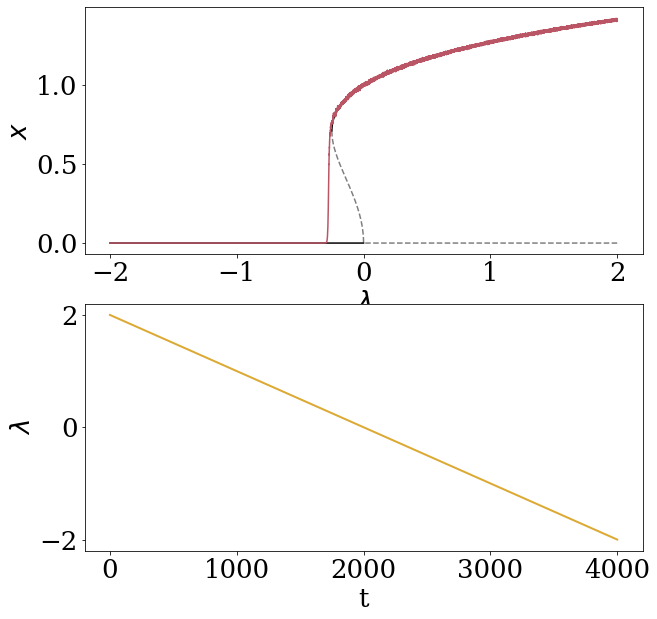

In [50]:
def G(x, t):
    #B=[ 'noise in x'         0    ]
    #  [      0        'noise in r']
    B = np.diag([s*x[0]]) # diagonal, so independent driving Wiener processes
    #the only parameter with relevant aditive noise is X(t) in this case. 
    return B
np.random.seed(1) #set numpy.random seed for reproducibility whenever it might be used.
l_var=np.linspace(lf,l0,20)
l=l0+cl*tspan
dl=cl*tspan[1]-l0


result2 = sdeint.stratHeun(f, G, x0, tspan)
print('Integration DOOONNEE')

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(l,result2[:,0],color=c2,zorder=10)
plt.plot(l[l>-0.25],np.sqrt(1/2)*np.sqrt(1+np.sqrt(1+4*l[l>-0.25])),'-',color='black')
plt.plot(l[l<0],0*l[l<0],'-k')
plt.plot(l[l>0],0*l[l>0],'--k',alpha=0.5)
plt.plot(l[(l<0) & (l>-0.25)],m_inest_1(l),'--k',alpha=0.5)

#lt.plot(result[result[:,1]>0,1],result[result[:,1]>0,0],'r')
plt.xlabel(r'$\lambda$')
plt.ylabel('$x$')
plt.subplot(212)
plt.plot(tspan,l,color=c1,lw=2)
plt.xlabel('t')
plt.ylabel(r'$\lambda$')
#print('$\dot{r}$: ',dot_r,(result[2,1]-result[1,1])/(tspan[2]-tspan[1]) )
print('$dt$: ',tspan[2]-tspan[1])


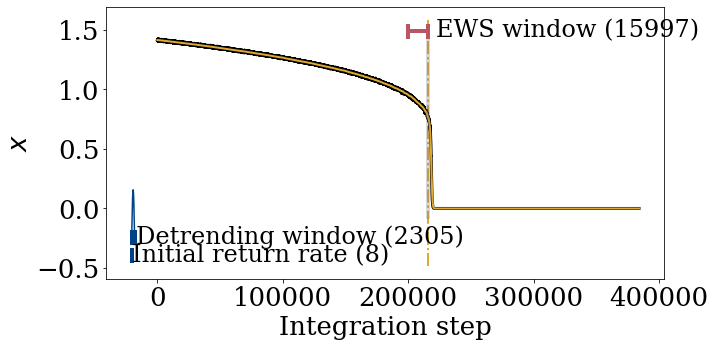

In [51]:
from scipy import signal

bootstrapping=False
smoothing=True

bif_idx=np.abs(-0.25-l).argmin()

trans=bif_idx
res=result2[:,0]
dlen=len(res)
t=np.arange(0,len(res),1)
ind_f=t
adiab_idx=np.abs(adiab-l).argmin()
adiab2_idx=np.abs(adiab2-l).argmin()


ts = ews.TimeSeries(data=res)  ### ews stats ### 

if smoothing==True:
    ts.detrend(method='Gaussian',bandwidth=bw, span=varwin)
    smooth=ts.state['smoothing'].values
    residuals=ts.state['residuals'].values
    data=residuals

    fig=plt.figure(figsize=(20,10))
    ax=fig.add_subplot(111)
    plt.plot(t,res,'-',color='black',lw=3)
    plt.plot(t,smooth,color=c1,lw=2)
    
    sa.plot_detrend(fig, ewswin,varwin,t_rm,dt,bw,trans)
ylim=ax.get_ylim()
ax.plot([adiab_idx,adiab_idx],ylim,':',linewidth=2,color=c1,alpha=1,label='Bifurcation',zorder=0)
ax.plot([adiab2_idx,adiab2_idx],ylim,'-.',linewidth=2,color=c1,alpha=1,label='Bifurcation',zorder=0)


In [52]:
tidx,ac_labels,ac1,ac2,var_ews,sk_ews,ku_ews,rtw,hogg2,moors,RTWc= sa.make_stats(tspan,t,ts,varwin,ewswin,sm=smoothing)

if bootstrapping==True:
    dlen=len(ac1)
    mean_b=np.zeros([dlen,2])
    var_b=np.zeros([dlen,2])
    skew_b=np.zeros([dlen,2])
    kur_b=np.zeros([dlen,2])
    kr2_b=np.zeros([dlen,2])
    kr3_b=np.zeros([dlen,2])
    RTW_b=np.zeros([dlen,2])
    ac1_std=np.zeros([dlen,2])


C:\Users/gomel/Documents/Programing Proyects/EE indicators/Simulations with pdfs to test/Stochastic equations/SDE tests jupyter\sde_analysis.py:161: RuntimeWarning: divide by zero encountered in true_divide
  vac=-var_ews/(ac1-1)
C:\Users/gomel/Documents/Programing Proyects/EE indicators/Simulations with pdfs to test/Stochastic equations/SDE tests jupyter\sde_analysis.py:162: RuntimeWarning: overflow encountered in true_divide
  Mvar=-s**2/(2*var_ews)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\gomel\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2919: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


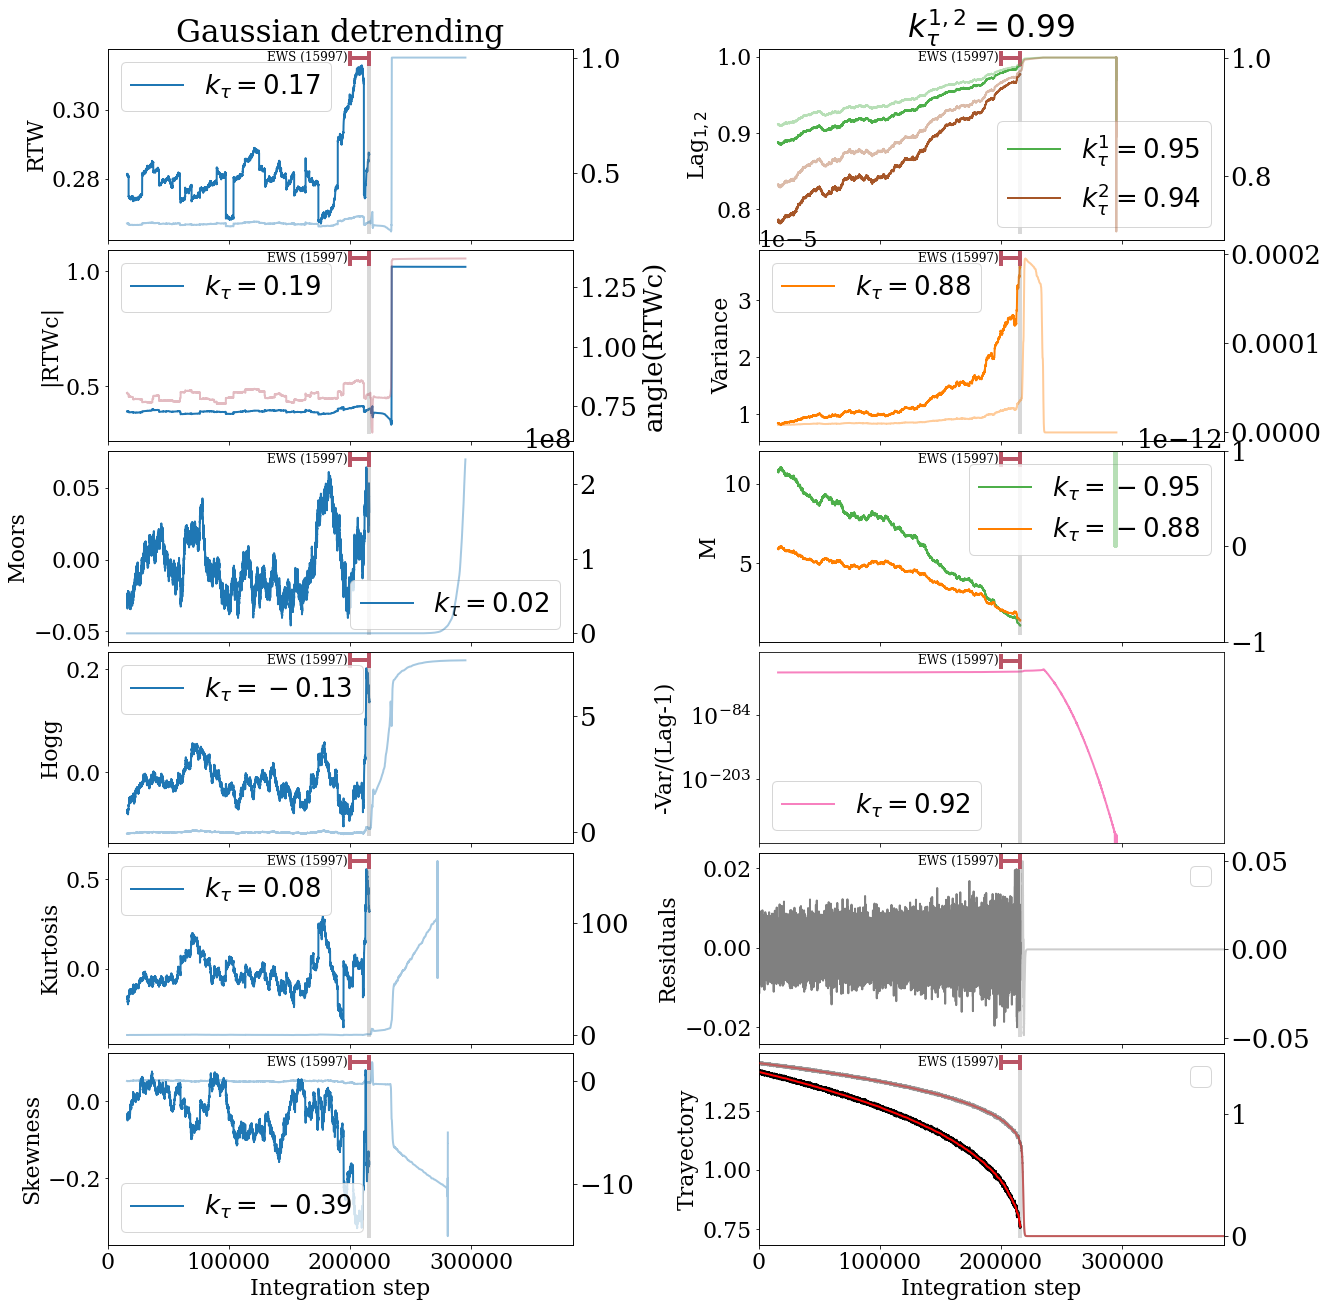

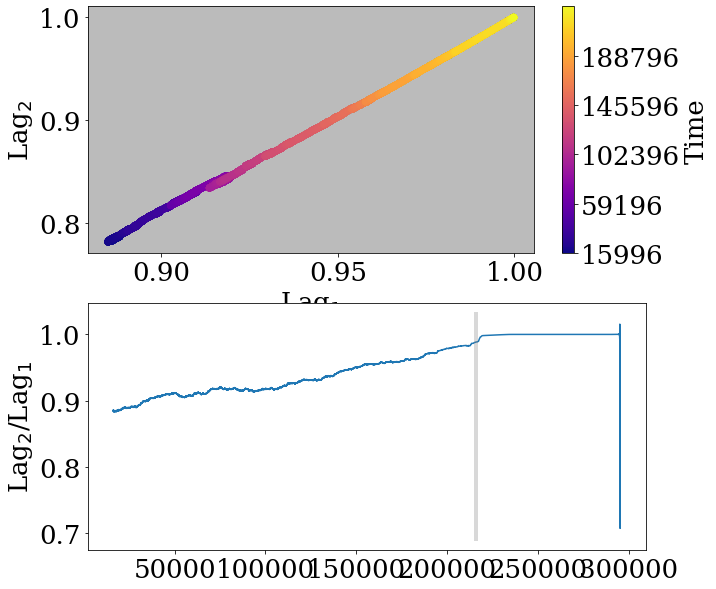

In [53]:

fig=sa.stats_plot(bif_idx,tidx,ind_f,s,rtw,RTWc,moors,hogg2,ac1,ku_ews,sk_ews,ac2,var_ews,residuals,res,smooth,smoothing,ewswin,datalen)
fig.savefig('./Gdet_multiplicative.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI
fig=sa.ac12_plot(ac1,ac2,tidx,bif_idx)

## not detrended data

In [54]:

bootstrapping=False
smoothing=False

ts = ews.TimeSeries(data=res)  ### ews stats ### 
data=res

if smoothing==True:
    ts.detrend(method='Gaussian',bandwidth=0.01, span=varwin)
    smooth=ts.state['smoothing'].values
    residuals=ts.state['residuals'].values
    data=residuals
    fig=plt.figure(figsize=(10,5))
    plt.plot(t,res)
    plt.plot(t,smooth)
    
    
tidx,ac_labels,ac1,ac2,var_ews,sk_ews,ku_ews,rtw,hogg2,moors,RTWc= sa.make_stats(tspan,t,ts,varwin,ewswin)

fig=sa.stats_plot(bif_idx,tidx,ind_f,s,rtw,RTWc,moors,hogg2,ac1,ku_ews,sk_ews,ac2,var_ews,residuals,res,smooth,smoothing,ewswin,datalen)
fig.savefig('./No_det_multiplicative.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI


C:\Users/gomel/Documents/Programing Proyects/EE indicators/Simulations with pdfs to test/Stochastic equations/SDE tests jupyter\sde_analysis.py:161: RuntimeWarning: divide by zero encountered in true_divide
  vac=-var_ews/(ac1-1)
C:\Users/gomel/Documents/Programing Proyects/EE indicators/Simulations with pdfs to test/Stochastic equations/SDE tests jupyter\sde_analysis.py:162: RuntimeWarning: overflow encountered in true_divide
  Mvar=-s**2/(2*var_ews)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\gomel\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2919: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


In [55]:
#cambiar kr2 por moors, pasar s como argument, o s*x

In [56]:

fig=sa.ac12_plot(ac1,ac2,tidx,bif_idx)

In [57]:


hogg2_b=np.zeros([len(tidx),2])
hogg2b=np.zeros([len(tidx)])
n_resample_case=500 #Bootstraping re-samples
sample_perc=70 #Bootstraping percentile
sk_b = [bts.boot_result(bts.blockbootstrap(metrics.Hogg2,data[j:tidx[j]],n_resample_case,rep=True,sd=1,perc=sample_perc)[0]) for j  in  range(len(tidx))]





KeyboardInterrupt



In [ ]:
tb=tidx[::np.int64(len(tidx)/2000)]

In [ ]:
len(tb)

In [ ]:
hogg2_b=np.zeros([len(tb),2])
hogg2b=np.zeros([len(tb)])
n_resample_case=10 #Bootstraping re-samples
sample_perc=70 #Bootstraping percentile
sk_b = [bts.boot_result(bts.blockbootstrap(metrics.Hogg2,data[j:tb[j]],n_resample_case,rep=True,sd=1,perc=sample_perc)[0]) for j  in  range(len(tb))]


hogg2_b=np.zeros([len(tb),2])
hogg2_b[:,0]=[sk_b[j][1][0] for j  in  range(len(tb))]
hogg2_b[:,1]=[sk_b[j][1][1] for j  in  range(len(tb))]



In [ ]:
fig=plt.figure(figsize=(20,20))
plt.plot(tidx,hogg2,'b',alpha=0.6)
plt.plot(tb,hogg2b,'b')
plt.fill_between(tb, hogg2_b[:,0], hogg2_b[:,1], color=CB_color_cycle[0], alpha=.4)

plt.plot([bif_idx,bif_idx],ylim,'-',linewidth=4,color='gray',alpha=0.3)


In [ ]:
mr_b=np.zeros([len(tb),2])
mrb=np.zeros([len(tb)])
n_resample_case=10 #Bootstraping re-samples
sample_perc=70 #Bootstraping percentile
sk_b = [bts.boot_result(bts.blockbootstrap(metrics.Moors,data[j:tb[j]],n_resample_case,rep=True,sd=1,perc=sample_perc)[0]) for j  in  range(len(tb))]


mrb=[sk_b[j][0] for j  in  range(len(tb))]
mr_b[:,0]=[sk_b[j][1][0] for j  in  range(len(tb))]
mr_b[:,1]=[sk_b[j][1][1] for j  in  range(len(tb))]



In [ ]:
mrb=[sk_b[j][0] for j  in  range(len(tb))]
mr_b[:,0]=[sk_b[j][1][0] for j  in  range(len(tb))]
mr_b[:,1]=[sk_b[j][1][1] for j  in  range(len(tb))]

fig=plt.figure(figsize=(20,20))
plt.plot(tidx,moors,'b',alpha=0.6)
plt.plot(tb,mrb,'b')
plt.fill_between(tb, mr_b[:,0], mr_b[:,1], color=CB_color_cycle[0], alpha=.4)

plt.plot([bif_idx,bif_idx],ylim,'-',linewidth=4,color='gray',alpha=0.3)
plt.ylim([-1,3])

In [ ]:
ewswin

In [ ]:
len(res)/2000